In [1]:
# CARGAMOS LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

import boto3
import s3fs
import fastparquet
import awswrangler as wr
import os

import pyarrow.parquet as pq
import pyarrow as pa

import requests
import json
from io import BytesIO
from pandas.tseries.offsets import BDay

import math

In [5]:
# INICIALIZAMOS UNA SESION EN AWS
session = boto3.Session(
    aws_access_key_id=os.environ['S3_ACCESS_KEY'],
    aws_secret_access_key=os.environ['S3_SECRET_KEY'],
    region_name=os.environ['S3_REGION'])

s3_client = boto3.client('s3')

OBJETIVO DE ESTE NOTEBOOK:
- DESCARGAR DE DISTINTOS ORIGENES LOS DATOS DE LOS ACTIVOS DEL IBEX35
- COMPARAR LOS DATOS OBTENIDOS 

## CARGA DE COMPOSICIÓN HISTÓRICA DE IBEX35

In [6]:
# LEEMOS EL FICHERO CON LA COMPOSICIÓN HISTORICA
ibex_constituents = pd.read_excel('data_processing/Historical Composition IBEX35.xlsx')
ibex_constituents.head()

,Activo,Inclusion,Exclusion
0,ACE,1991-01-02,2003-06-02
1,ACX,1991-01-02,1991-07-01
2,ALB,1991-01-02,1991-07-01
3,ASL,1991-01-02,1994-01-03
4,BBV,1991-01-02,2000-01-31


In [7]:
ibex_constituents[ibex_constituents['Ticker'] == 'EZE']

KeyError: 'Ticker'

In [8]:
ibex_constituents.Ticker.replace('RAD','EZE',inplace=True)
# CAMBIAR BBV POR BBVA
# CAMBIAR PUL, EVA Y EBA POR EBRO
# CAMBIAR RAD POR EZE
# ibex_constituents.Ticker.replace('BBVAA','BBVA',inplace=True)

AttributeError: 'DataFrame' object has no attribute 'Ticker'

In [ ]:
# ibex_constituents['Exclusion'] -= BDay(1)

# ibex_constituents['Inclusion'] = ibex_constituents['Inclusion'].dt.date
# ibex_constituents['Exclusion'] = ibex_constituents['Exclusion'].dt.date

# OBTENEMOS EL DIA ACTUAL
today = datetime.date.today().strftime('%Y-%m-%d')

# COMPLETAMOS LOS DATOS NULOS EN EL FICHERO DE COMPOSICIÓN HISTORICA CON LA FECHA ACTUAL
ibex_constituents.fillna(today,inplace=True)

# DEFINIMOS UNA VARIABLE PARA TODOS LOS ACTIVOS
activos = ibex_constituents.Activo
ibex_constituents['Ticker'] = activos.apply(lambda x: x.split('_')[0])

unique_activos = list(set(activos))

## DESCARGA DE DATOS CON API DE MARKETSTACK 

In [9]:
# OBTENEMOS TODOS LOS EXCHANGES
url = f'http://api.marketstack.com/v1/'
exchange_list = 'exchanges'

r = requests.get(url+exchange_list,params={
    'access_key':API_TOKEN
    })
# print(r.content)
exchanges = pd.DataFrame(json.load(BytesIO(r.content))['data'])
exchanges


,name,acronym,mic,country,country_code,city,website,timezone,currency
0,NASDAQ Stock Exchange,NASDAQ,XNAS,USA,US,New York,www.nasdaq.com,"{'timezone': 'America/New_York', 'abbr': 'EST'...","{'code': 'USD', 'symbol': '$', 'name': 'US Dol..."
1,New York Stock Exchange,NYSE,XNYS,USA,US,New York,www.nyse.com,"{'timezone': 'America/New_York', 'abbr': 'EST'...","{'code': 'USD', 'symbol': '$', 'name': 'US Dol..."
2,NYSE ARCA,NYSEARCA,ARCX,USA,US,New York,www.nyse.com,"{'timezone': 'America/New_York', 'abbr': 'EST'...","{'code': 'USD', 'symbol': '$', 'name': 'US Dol..."
3,OTC Markets,,OTCM,USA,US,New York,www.otcmarkets.com,"{'timezone': 'America/New_York', 'abbr': 'EST'...","{'code': 'USD', 'symbol': '$', 'name': 'US Dol..."
4,Buenos Aires Stock Exchange,BCBA,XBUE,Argentina,AR,Buenos Aires,www.bcba.sba.com.ar,"{'timezone': 'America/Argentina/Buenos_Aires',...","{'code': 'ARS', 'symbol': 'AR$', 'name': 'Arge..."
...,...,...,...,...,...,...,...,...,...
64,OTCQB Marketplace,OTCQB,OTCB,USA,US,New York,www.otcmarkets.com,"{'timezone': 'America/New_York', 'abbr': 'EST'...","{'code': 'USD', 'symbol': '$', 'name': 'US Dol..."
65,OTCQX Marketplace,OTCQX,OTCQ,USA,US,New York,www.otcmarkets.com,"{'timezone': 'America/New_York', 'abbr': 'EST'...","{'code': 'USD', 'symbol': '$', 'name': 'US Dol..."
66,OTC PINK current,PINK,PINC,USA,US,New York,www.otcmarkets.com,"{'timezone': 'America/New_York', 'abbr': 'EST'...","{'code': 'USD', 'symbol': '$', 'name': 'US Dol..."
67,Investors Exchange,IEX,IEXG,USA,US,New York,www.iextrading.com,"{'timezone': 'America/New_York', 'abbr': 'EST'...","{'code': 'USD', 'symbol': '$', 'name': 'US Dol..."


In [10]:
spain_ex_code = exchanges.loc[exchanges['country']=='Spain','mic'].values[0]
spain_ex_code

'BMEX'

In [11]:
# OBTENEMOS UNA LISTA DE LOS ACTIVOS DISPONIBLES EN MARKETSTACK
spain_ex_code = exchanges.loc[exchanges['country']=='Spain','mic'].values[0]

symbol_list = 'tickers'

r = requests.get(url+symbol_list,
                 params={
                    'access_key': API_TOKEN,
                    'exchange': spain_ex_code,
                    'limit':1000
                    }
                )
# print(r.content)
symbols = pd.DataFrame(json.load(BytesIO(r.content))['data'])
symbols

,name,symbol,has_intraday,has_eod,country,stock_exchange
0,INDUSTRIA DE DISEO TEXTIL S.A. INDITEX-,ITX.BMEX,False,True,None,"{'name': 'Bolsas y Mercados Españoles', 'acron..."
1,AIRBUS,AIR.BMEX,False,True,None,"{'name': 'Bolsas y Mercados Españoles', 'acron..."
2,"PETROLEO BRASILEIRO,S.A. -PETROBRAS- ORDINARIAS",XPBR.BMEX,False,False,None,"{'name': 'Bolsas y Mercados Españoles', 'acron..."
3,ACCIONES IBERDROLA,IBE.BMEX,False,True,None,"{'name': 'Bolsas y Mercados Españoles', 'acron..."
4,BANCO SANTANDER S.A.,SAN.BMEX,False,True,None,"{'name': 'Bolsas y Mercados Españoles', 'acron..."
...,...,...,...,...,...,...
304,Silicius Real Estate SOCIMI S.A.,YSIL.BMEX,False,True,Spain,"{'name': 'Bolsas y Mercados Españoles', 'acron..."
305,Tempore Properties SOCIMI SAU,YTEM.BMEX,False,True,Spain,"{'name': 'Bolsas y Mercados Españoles', 'acron..."
306,Urban View Development Spain SOCIMI S.A.,YUVS.BMEX,False,True,Spain,"{'name': 'Bolsas y Mercados Españoles', 'acron..."
307,Veracruz Properties SOCIMI SA,YVCP.BMEX,False,True,Spain,"{'name': 'Bolsas y Mercados Españoles', 'acron..."


In [12]:
ibex_constituents[ibex_constituents['Activo'].isin(['SCYR','SCYR_1','SCYR_2'])].index

Int64Index([103, 109, 141], dtype='int64')

In [101]:
# REALIZAMOS LA DESCARGA DE LOS DATOS DE MARKETSTACK Y LOS CARGAMOS EN UN BUCKET DE S3
bucket_name = 'stock-market-historical-data'
raw_folder = 'preprocessed/marketstack/'
s3 = boto3.resource('s3')
failed_loads = []
eod_data = 'eod'
indexes = ibex_constituents[ibex_constituents['Ticker'].isin(['EZE'])].index

# for i in range(ibex_constituents.shape[0]):
for i in indexes:

    try:
        ticker = ibex_constituents.Ticker[i] + '.BMEX'
        file_name = ibex_constituents.Activo[i] +'.parquet'
        start_date = ibex_constituents.Inclusion[i]
        end_date = ibex_constituents.Exclusion[i]# + datetime.timedelta(days=6000)
        full_path = raw_folder + file_name

        total_days = (end_date.to_period('D') - start_date.to_period('D')).n/1000

        stock_data = pd.DataFrame()

        for _ in range(math.ceil(total_days)):
            try:
                prov_end_date = start_date + datetime.timedelta(days=1000)
                if prov_end_date > end_date:
                    r = requests.get(url+eod_data,
                            params={
                                'access_key': API_TOKEN,
                                'exchange': spain_ex_code,
                                'symbols':ticker,
                                'date_from': start_date,
                                'date_to': end_date,
                                'limit':1000
                                }
                            )
                    print('OK')
                else:
                    r = requests.get(url+eod_data,
                            params={
                                'access_key': API_TOKEN,
                                'exchange': spain_ex_code,
                                'symbols':ticker,
                                'date_from': start_date,
                                'date_to': prov_end_date,
                                'limit': 1000
                                }
                            )
                    print('NOK')
                
                print(start_date,prov_end_date)
                print(type(start_date),type(prov_end_date))
                ticker_data = pd.DataFrame(json.load(BytesIO(r.content))['data'])
                ticker_data.set_index('date', inplace=True)

                stock_data = pd.concat([stock_data, ticker_data], axis=0)
                start_date = prov_end_date + datetime.timedelta(days=1)
            except:
                start_date = prov_end_date + datetime.timedelta(days=1)
                continue
                
        table = pa.Table.from_pandas(stock_data)
        buf = BytesIO()
        pq.write_table(table, buf)
        
        s3.Object(bucket_name, full_path).put(Body=buf.getvalue())
        print(ibex_constituents.Activo[i])
    except:
        print('failed')
        failed_loads.append(ticker)
        continue

OK
1999-04-19 00:00:00 2002-01-13 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'> <class 'pandas._libs.tslibs.timestamps.Timestamp'>
RAD


In [102]:
stock_data.index = pd.to_datetime(stock_data.index)

In [105]:
stock_data

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange
date,,,,,,,,,,,,,,
1999-07-01 00:00:00+00:00,47.5001,47.6000,46.8500,47.5799,77764.78,None,None,36.5112,None,None,1.0,0.0,EZE.BMEX,BMEX
1999-06-30 00:00:00+00:00,47.1000,48.4401,46.4300,47.5599,143312.44,None,None,36.4959,None,None,1.0,0.0,EZE.BMEX,BMEX
1999-06-29 00:00:00+00:00,46.1000,46.8999,45.5500,46.6000,62562.12,None,None,35.7592,None,None,1.0,0.0,EZE.BMEX,BMEX
1999-06-28 00:00:00+00:00,47.5001,47.5001,46.0000,46.0000,77591.46,None,None,35.2988,None,None,1.0,0.0,EZE.BMEX,BMEX
1999-06-25 00:00:00+00:00,47.9001,47.9900,47.2700,47.6599,12550.74,None,None,36.5726,None,None,1.0,0.0,EZE.BMEX,BMEX
1999-06-24 00:00:00+00:00,47.9998,48.9400,47.6101,48.2500,30298.48,None,None,37.0254,None,None,1.0,0.0,EZE.BMEX,BMEX
1999-06-23 00:00:00+00:00,48.9999,48.9999,48.0199,48.1000,12346.14,None,None,36.9103,None,None,1.0,0.0,EZE.BMEX,BMEX
1999-06-22 00:00:00+00:00,49.1999,49.5999,48.3599,48.8000,16830.31,None,None,37.4474,None,None,1.0,0.0,EZE.BMEX,BMEX
1999-06-21 00:00:00+00:00,47.9998,49.6900,47.4000,49.0199,39965.32,None,None,37.6162,None,None,1.0,0.0,EZE.BMEX,BMEX


<AxesSubplot: xlabel='date'>

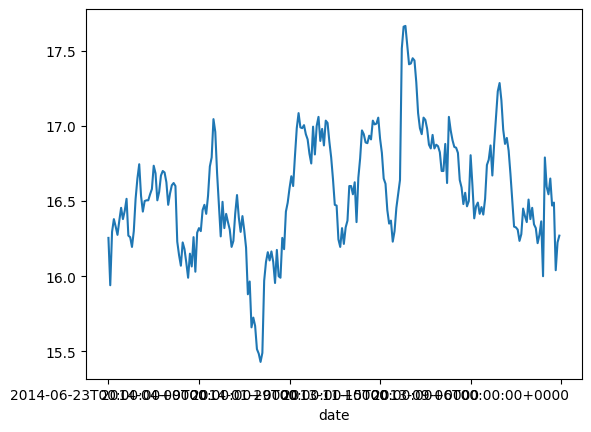

In [84]:
stock_data['close'].plot()

In [13]:
indexes = ibex_constituents[ibex_constituents['Activo'].isin(['PUL'])].index
indexes[0]

70

In [20]:
# REALIZAMOS LA DESCARGA DE LOS DATOS DE MARKETSTACK Y LOS CARGAMOS EN UN BUCKET DE S3
bucket_name = 'stock-market-historical-data'
raw_folder = 'preprocessed/marketstack/'
s3 = boto3.resource('s3')
failed_loads = []
eod_data = 'eod'

r = requests.get(url+eod_data,
                            params={
                                'access_key': API_TOKEN,
                                'exchange': 'BMEX',
                                'symbols':'MTS.BMEX',
                                'date_from':'1998-04-19',
                                'date_to':'2002-02-09',
                                'limit':1000,
                                # 'sort':'DESC'
                                # 'offset':4790
                                }
                            )

print(r.content)

b'{"pagination":{"limit":1000,"offset":0,"count":0,"total":0},"data":[]}'


In [19]:
pd.DataFrame(json.load(BytesIO(r.content))['data'])

""


In [106]:
raw_folder = 'preprocessed/marketstack/'
raw_path = bucket_name + raw_folder
objects_dict = s3_client.list_objects_v2(
        Bucket=bucket_name,
        Prefix ='preprocessed/marketstack')
raw_filepaths = [item['Key'] for item in objects_dict['Contents'] if item['Key'].endswith('.parquet')]
act_list = [i.split('/')[-1].replace('.parquet','') for i in raw_filepaths]

In [107]:
ibex_historical_data = {}
processed_folder = 'processed/marketstack/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name

In [108]:
def download_s3_parquet_file(s3, bucket, key):
    buffer = BytesIO()
    s3.Object(bucket, key).download_fileobj(buffer)
    return buffer

In [109]:
# CARGAMOS EL DATAFRAME CON TODOS LOS DATOS DE CIERRE DE TODOS LOS ACTIVOS DESDE 02/01/1991
for i in range(len(raw_filepaths)):

    try:
        close_price = pq.read_table(download_s3_parquet_file(s3, bucket_name,raw_filepaths[i])).to_pandas()['adj_close']
        close_price.index = pd.to_datetime(close_price.index).strftime('%Y-%m-%d')
        ibex_historical_data[act_list[i]] = close_price
    except:
        ibex_historical_data[act_list[i]] = np.nan
        

ibex_historical_data = pd.DataFrame(ibex_historical_data)

table = pa.Table.from_pandas(ibex_historical_data)
buf = BytesIO()
pq.write_table(table, buf)

s3.Object(bucket_name, full_path).put(Body=buf.getvalue())

{'ResponseMetadata': {'RequestId': 'NZBBRR8198DFS5QD',
  'HostId': 'Ha6uK4HHOwXGyB1DZltrcOKVSa+AWw7l+f0PV4Z4NU0aToyykPpX/z2jwuA46NO8eVyIZ8WeZws=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Ha6uK4HHOwXGyB1DZltrcOKVSa+AWw7l+f0PV4Z4NU0aToyykPpX/z2jwuA46NO8eVyIZ8WeZws=',
   'x-amz-request-id': 'NZBBRR8198DFS5QD',
   'date': 'Mon, 14 Aug 2023 22:24:51 GMT',
   'x-amz-version-id': '5Ut.rpAxOziYWgNnF0xP8MzZmxczRFw.',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"c8a3ff8d8ae416dbccebf2bc9c5dca93"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"c8a3ff8d8ae416dbccebf2bc9c5dca93"',
 'ServerSideEncryption': 'AES256',
 'VersionId': '5Ut.rpAxOziYWgNnF0xP8MzZmxczRFw.'}

In [111]:
ibex_historical_data['RAD'].dropna()

date
1999-04-19    43.3561
1999-04-20    41.6296
1999-04-21    41.7447
1999-04-22    40.7471
1999-04-23    41.8981
1999-04-26    41.7830
1999-04-27    42.2051
1999-04-28    42.1667
1999-04-29    41.9365
1999-04-30    41.2075
1999-05-03    40.7471
1999-05-04    40.2867
1999-05-05    39.5193
1999-05-06    39.8263
1999-05-07    39.7112
1999-05-10    40.2867
1999-05-11    39.6728
1999-05-12    39.4042
1999-05-13    39.4809
1999-05-14    39.5193
1999-05-17    39.7495
1999-05-18    40.9773
1999-05-19    41.1308
1999-05-20    42.4737
1999-05-21    41.8598
1999-05-24    41.8214
1999-05-25    41.4377
1999-05-26    41.5145
1999-05-27    40.3634
1999-05-28    40.5553
1999-05-31    40.5169
1999-06-01    39.2891
1999-06-02    39.8263
1999-06-03    39.4426
1999-06-04    39.4426
1999-06-07    39.1356
1999-06-08    38.4834
1999-06-09    39.4042
1999-06-10    38.9822
1999-06-11    39.5193
1999-06-14    38.9438
1999-06-15    37.7160
1999-06-16    37.0637
1999-06-17    35.7209
1999-06-18    36.2580
1999-

In [95]:
ibex_historical_data

{}

In [1]:
ibex_historical_data.notna().sum(axis=1)

NameError: name 'ibex_historical_data' is not defined

<AxesSubplot: xlabel='date'>

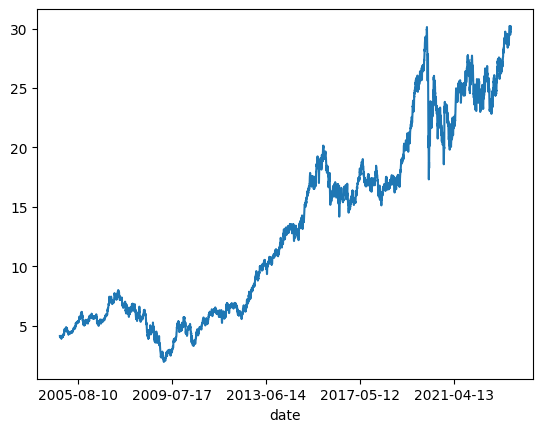

In [83]:
ibex_historical_data['FER'].plot()

In [94]:
failed_loads = ibex_historical_data.columns[ibex_historical_data.isnull().values.all(axis=0)]
failed_loads, len(failed_loads)

AttributeError: 'dict' object has no attribute 'columns'